In [1]:
import kaggle
import os
import segmentation_models_pytorch as smp
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2


from PIL import Image
from albumentations.pytorch import ToTensorV2
from kaggle.api.kaggle_api_extended import KaggleApi
from torch.utils.data import Dataset
from tqdm import tqdm
from torchvision import transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
api = KaggleApi()
api.authenticate()
api.model_list_cli()

# Download the dataset
if os.path.exists('dataset/RGB_color_image_masks'):
    print('Dataset already downloaded')
else:
    api.dataset_download_files('bulentsiyah/semantic-drone-dataset')

Next Page Token = CfDJ8GYiNaMVVSVCnegdIdgHCPOEdkFpLOUZDAd5znHQxQZj68PDi97CIFt3bCW7X02o_MMtPOxcpzXiSpVIg2ub9M4
   id  ref                                                       title                                             subtitle                                                                                                                                                                                                        author              
-----  --------------------------------------------------------  ------------------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  ------------------  
 3301  google/gemma                                              Gemma                                             Gemma is a family of lightweight, open models built from the research and technology th

In [68]:
segmentation_train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    #A.GaussNoise(var_limit=(5, 20), p=0.5),
    #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25, p=0.5),
    #A.Blur(blur_limit=3, p=0.5),
    #A.RandomGamma(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    #A.ElasticTransform(alpha=1.0, sigma=50.0, alpha_affine=50.0, p=0.5),
    #A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    #A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=0.5),
    #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.5),
    ToTensorV2(),
])

# pytorch transforms
segmentation_valtest_transform = A.Compose([
    ToTensorV2(),
])

In [69]:
path_img = './dataset/original_images/'
path_mask = './dataset/label_images_semantic/'

name = []
for filename in os.listdir(path_img):
    if os.path.isfile(os.path.join(path_img, filename)):
        name.append(os.path.splitext(filename)[0])

df = pd.DataFrame({'name': name}, index=np.arange(0, len(name)))
df

,name
0,316
1,303
2,517
3,310
4,376
...,...
395,077
396,545
397,171
398,479


In [5]:
classes = pd.read_csv('dataset/class_dict_seg.csv', sep=',')
num_classes = len(classes)
classes

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [139]:
import numpy as np

class ImagePatchDataset(Dataset):
    def __init__(self, img_dir, mask_dir, patch_size=(512, 512), overlap=0, transform=None, precompute=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.patch_size = patch_size
        self.overlap = overlap
        self.img_files = os.listdir(img_dir)
        self.transform = transform
        self.precompute = False
        
        if self.precompute:
            self.cached_data = []
            for img_file in self.img_files:
                img_path = os.path.join(self.img_dir, img_file)
                mask_path = os.path.join(self.mask_dir, img_file.replace('.jpg', '.png'))
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                self.cached_data.append((img, mask))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        
        if self.precompute:
            img, mask = self.cached_data[idx]
        else:
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '.png'))
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img_patches = self.create_patches_torch(img)
        mask_patches = self.create_patches_torch(mask)

        if self.transform:
            img_patches, mask_patches = self.apply_transform(img_patches, mask_patches)

        return img_patches, mask_patches

    def create_patches_numpy(self, img):
        height, width = img.shape[:2]
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap

        num_patches_height = (height - patch_height) // stride_height + 1
        num_patches_width = (width - patch_width) // stride_width + 1

        if len(img.shape) == 2:
            # 2D array (grayscale image or mask)
            shape = (num_patches_height, num_patches_width, patch_height, patch_width)
            strides = (stride_height * img.strides[0], stride_width * img.strides[1]) + img.strides
            patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
            patches = patches.reshape(-1, patch_height, patch_width)
        else:
            # 3D array (RGB image)
            shape = (num_patches_height, num_patches_width, patch_height, patch_width) + img.shape[2:]
            strides = (stride_height * img.strides[0], stride_width * img.strides[1]) + img.strides
            patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
            patches = patches.reshape(-1, patch_height, patch_width, img.shape[2])

        return patches

    def create_patches_torch(self, img):
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap
        
        patches = []
        
        for y in range(0, img.shape[0] - patch_height + 1, stride_height):
            for x in range(0, img.shape[1] - patch_width + 1, stride_width):
                patch = img[y:y+patch_height, x:x+patch_width]
                patches.append(patch)
        
        return np.array(patches)

    def apply_transform(self, img_patches, mask_patches):
        transformed_img_patches = []
        transformed_mask_patches = []

        for img_patch, mask_patch in zip(img_patches, mask_patches):
            transformed = self.transform(image=img_patch, mask=mask_patch)
            transformed_img_patches.append(transformed['image'])
            transformed_mask_patches.append(transformed['mask'])

        return np.array(transformed_img_patches), np.array(transformed_mask_patches)

In [274]:
import os
import cv2
import numpy as np
import torch.nn.functional as F  # Import F from torch.nn.functional
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2


class ImagePatchDataset(Dataset):
    def __init__(self, img_dir, mask_dir, patch_size=(512, 512), overlap=0, transform=None, use_torch=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.patch_size = patch_size
        self.overlap = overlap
        self.img_files = os.listdir(img_dir)
        self.transform = transform
        self.use_torch = use_torch

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '.png'))
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Image and mask sizes do not match for {self.img_files[idx]}")

        if self.use_torch:
            img_patches = self.create_patches_torch(img)
            mask_patches = self.create_patches_torch(mask)
        else:
            img_patches = self.create_patches_numpy(img)
            mask_patches = self.create_patches_numpy(mask)

        if self.transform:
            img_patches, mask_patches = self.apply_transform(img_patches, mask_patches)

        return img_patches, mask_patches

    def create_patches_numpy(self, img):
        height, width = img.shape[:2]
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap

        patches = []
        for y in range(0, height, stride_height):
            for x in range(0, width, stride_width):
                # Adjust the patch boundaries if they exceed the image dimensions
                end_y = min(y + patch_height, height)
                end_x = min(x + patch_width, width)
                start_y = max(0, end_y - patch_height)
                start_x = max(0, end_x - patch_width)

                if len(img.shape) == 2:
                    patch = img[start_y:end_y, start_x:end_x]
                    patch = np.expand_dims(patch, axis=2)
                else:
                    patch = img[start_y:end_y, start_x:end_x, :]

                # Pad the patch if it's smaller than the desired size
                if patch.shape[:2] != (patch_height, patch_width):
                    pad_height = patch_height - patch.shape[0]
                    pad_width = patch_width - patch.shape[1]
                    patch = np.pad(patch, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

                patches.append(patch)

        return np.array(patches)

    def create_patches_torch(self, img):
        # Convert image to tensor if it's not already
        if not isinstance(img, torch.Tensor):
            img_tensor = torch.from_numpy(img).float()
        else:
            img_tensor = img.float()

        # Ensure the tensor is in the format [C, H, W]
        if len(img_tensor.shape) == 2:
            img_tensor = img_tensor.unsqueeze(0)
        elif len(img_tensor.shape) == 3 and img_tensor.shape[2] in [1, 3]:
            img_tensor = img_tensor.permute(2, 0, 1)

        C, H, W = img_tensor.shape
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap

        # Calculate padding
        pad_height = (patch_height - H % stride_height) % patch_height
        pad_width = (patch_width - W % stride_width) % patch_width

        # Pad the image
        img_padded = F.pad(img_tensor, (0, pad_width, 0, pad_height), mode='constant', value=0)

        # Use unfold to create patches
        patches = img_padded.unfold(1, patch_height, stride_height).unfold(2, patch_width, stride_width)
        patches = patches.contiguous().view(C, -1, patch_height, patch_width)
        patches = patches.permute(1, 0, 2, 3)

        return patches

    # Method to get the number of patches
    def get_num_patches(self, img_shape):
        H, W = img_shape[:2]
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap

        num_patches_height = (H - patch_height) // stride_height + 1
        num_patches_width = (W - patch_width) // stride_width + 1

        return num_patches_height, num_patches_width


    def apply_transform(self, img_patches, mask_patches):
        transformed_img_patches = []
        transformed_mask_patches = []

        for img_patch, mask_patch in zip(img_patches, mask_patches):
            transformed = self.transform(image=img_patch, mask=mask_patch)
            transformed_img_patches.append(transformed['image'])
            transformed_mask_patches.append(transformed['mask'])

        # Ensure all patches have the same shape
        img_shapes = set(img.shape for img in transformed_img_patches)
        mask_shapes = set(mask.shape for mask in transformed_mask_patches)

        if len(img_shapes) > 1 or len(mask_shapes) > 1:
            # If shapes are inconsistent, resize to the original patch size
            patch_height, patch_width = self.patch_size
            transformed_img_patches = [self.resize_patch(img, (patch_width, patch_height)) for img in transformed_img_patches]
            transformed_mask_patches = [self.resize_patch(mask, (patch_width, patch_height), is_mask=True) for mask in transformed_mask_patches]

        return np.array(transformed_img_patches), np.array(transformed_mask_patches)
    
    def resize_patch(self, patch, size, is_mask=False):
        if isinstance(patch, torch.Tensor):
            patch = patch.cpu().numpy()
        
        if patch.ndim == 3 and patch.shape[0] in [1, 3]:  # CHW format
            patch = np.transpose(patch, (1, 2, 0))
        
        if is_mask:
            resized = cv2.resize(patch, size, interpolation=cv2.INTER_NEAREST)
        else:
            resized = cv2.resize(patch, size)
        
        if patch.ndim == 3 and patch.shape[-1] == 1:
            resized = resized[..., np.newaxis]
        
        return resized

    def get_original_image(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

# Test function
def test_dataset(img_dir, mask_dir, patch_size=(512, 512), use_torch=False):
    dataset = ImagePatchDataset(img_dir, mask_dir, patch_size=patch_size, use_torch=use_torch)
    
    for i in range(min(5, len(dataset))):
        img_patches, mask_patches = dataset[i]
        print(f"Sample {i+1}:")
        print(f"  Number of patches: {len(img_patches)}")
        print(f"  Image patches shape: {img_patches.shape}")
        print(f"  Mask patches shape: {mask_patches.shape}")
        print(f"  First image patch shape: {img_patches[0].shape}")
        print(f"  First mask patch shape: {mask_patches[0].shape}")
        print()

# Run the test
img_dir = 'dataset/original_images/'
mask_dir = 'dataset/label_images_semantic/'

test_dataset(img_dir, mask_dir, patch_size=(512, 512), use_torch=False)
print("Testing with PyTorch method:")
test_dataset(img_dir, mask_dir, patch_size=(512, 512), use_torch=True)

Sample 1:
  Number of patches: 96
  Image patches shape: (96, 512, 512, 3)
  Mask patches shape: (96, 512, 512, 1)
  First image patch shape: (512, 512, 3)
  First mask patch shape: (512, 512, 1)

Sample 2:
  Number of patches: 96
  Image patches shape: (96, 512, 512, 3)
  Mask patches shape: (96, 512, 512, 1)
  First image patch shape: (512, 512, 3)
  First mask patch shape: (512, 512, 1)

Sample 3:
  Number of patches: 96
  Image patches shape: (96, 512, 512, 3)
  Mask patches shape: (96, 512, 512, 1)
  First image patch shape: (512, 512, 3)
  First mask patch shape: (512, 512, 1)

Sample 4:
  Number of patches: 96
  Image patches shape: (96, 512, 512, 3)
  Mask patches shape: (96, 512, 512, 1)
  First image patch shape: (512, 512, 3)
  First mask patch shape: (512, 512, 1)

Sample 5:
  Number of patches: 96
  Image patches shape: (96, 512, 512, 3)
  Mask patches shape: (96, 512, 512, 1)
  First image patch shape: (512, 512, 3)
  First mask patch shape: (512, 512, 1)

Testing with Py

In [275]:
dataset = ImagePatchDataset(img_dir='dataset/original_images', mask_dir='dataset/label_images_semantic', patch_size=(4000, 6000), overlap=0, transform=segmentation_train_augmentation)

dataloaders = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=8)

In [276]:
len(dataset[0][0])

1

In [277]:
dataset[0][0][0].shape

(3, 6000, 4000)

In [278]:
len(dataset[0])

2

In [279]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def visualize_patches(dataset, num_samples=5, patches_per_sample=4):
    fig, axes = plt.subplots(num_samples, patches_per_sample * 2 + 1, figsize=(20, 4 * num_samples))
    
    for sample_idx in range(num_samples):
        # Get the original image and patches for the same index
        original_img = dataset.get_original_image(sample_idx)
        img_patches, mask_patches = dataset[sample_idx]
        
        print(f"Sample {sample_idx + 1}:")
        print(f"Original image shape: {original_img.shape}")
        print(f"Image patches shape: {img_patches.shape}")
        print(f"Mask patches shape: {mask_patches.shape}")
        
        # Display original image
        axes[sample_idx, 0].imshow(original_img)
        axes[sample_idx, 0].set_title(f'Original Image {sample_idx+1}')
        axes[sample_idx, 0].axis('off')
        
        for patch_idx in range(min(patches_per_sample, len(img_patches))):
            img_patch = img_patches[patch_idx]
            mask_patch = mask_patches[patch_idx]
            
            # Transpose image patch if necessary
            if img_patch.shape[0] == 3:  # If in (C, H, W) format
                img_patch = np.transpose(img_patch, (1, 2, 0))
            
            # Normalize image patch for visualization
            img_patch = (img_patch - img_patch.min()) / (img_patch.max() - img_patch.min())
            
            # Display image patch
            axes[sample_idx, patch_idx * 2 + 1].imshow(img_patch)
            axes[sample_idx, patch_idx * 2 + 1].set_title(f'Patch {patch_idx+1}')
            axes[sample_idx, patch_idx * 2 + 1].axis('off')
            
            # Ensure mask is 2D
            if mask_patch.ndim > 2:
                mask_patch = mask_patch.squeeze()
            
            # Display mask patch
            axes[sample_idx, patch_idx * 2 + 2].imshow(mask_patch, cmap='gray')
            axes[sample_idx, patch_idx * 2 + 2].set_title(f'Mask {patch_idx+1}')
            axes[sample_idx, patch_idx * 2 + 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example
img_dir = 'dataset/original_images/'
mask_dir = 'dataset/label_images_semantic/'
patch_size = (2000, 3000)  # Adjust as needed

# Create the dataset
dataset = ImagePatchDataset(img_dir, mask_dir, patch_size=patch_size)

# Visualize patches
visualize_patches(dataset, num_samples=5, patches_per_sample=4)

# Print some additional information
print(f"Total number of images in the dataset: {len(dataset)}")
print(f"Patch size: {patch_size}")
sample_img_patches, sample_mask_patches = dataset[0]
print(f"Number of patches per image: {len(sample_img_patches)}")
print(f"Shape of a single image patch: {sample_img_patches[0].shape}")
print(f"Shape of a single mask patch: {sample_mask_patches[0].shape}")

Sample 1:
Original image shape: (4000, 6000, 3)
Image patches shape: (4, 2000, 3000, 3)
Mask patches shape: (4, 2000, 3000, 1)
Sample 2:
Original image shape: (4000, 6000, 3)
Image patches shape: (4, 2000, 3000, 3)
Mask patches shape: (4, 2000, 3000, 1)
Sample 3:
Original image shape: (4000, 6000, 3)
Image patches shape: (4, 2000, 3000, 3)
Mask patches shape: (4, 2000, 3000, 1)
Sample 4:
Original image shape: (4000, 6000, 3)
Image patches shape: (4, 2000, 3000, 3)
Mask patches shape: (4, 2000, 3000, 1)


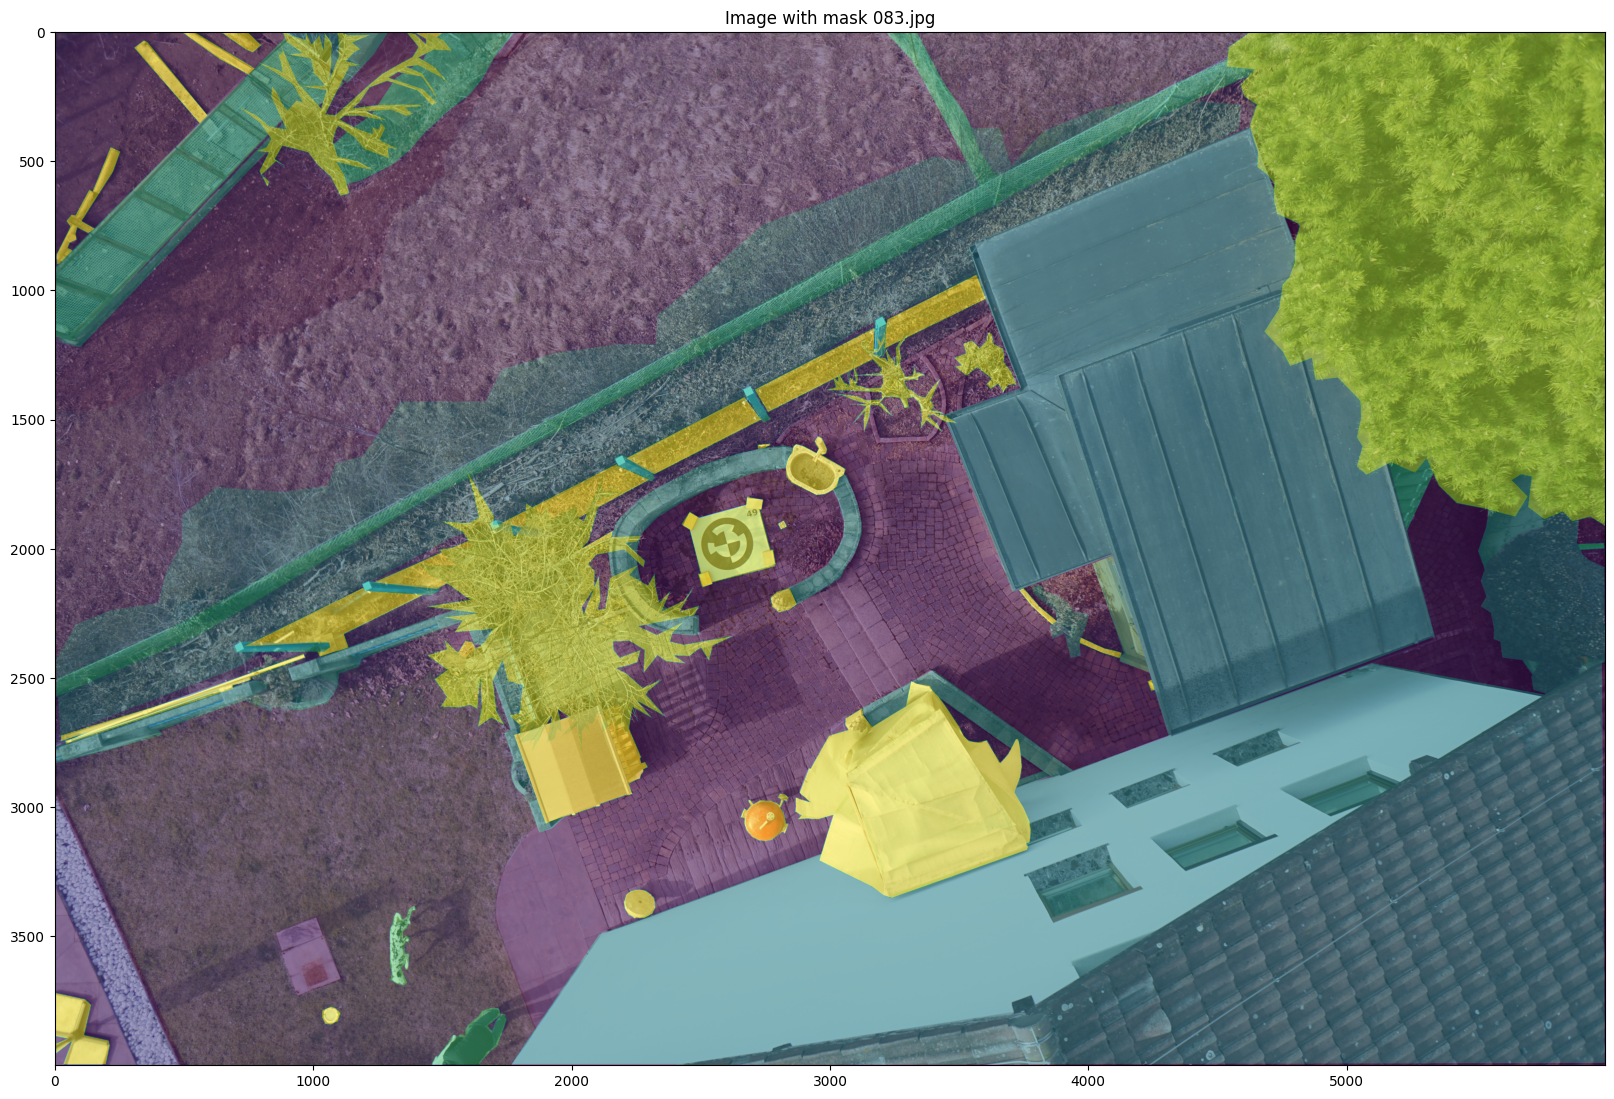

In [25]:
rnd = np.random.randint(0, len(df))
img = Image.open(os.path.join(path_img, df['name'][rnd] + '.jpg'))
mask = Image.open(os.path.join(path_mask, df['name'][rnd] + '.png'))

plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title(f'Image with mask {df["name"][rnd]}.jpg')
plt.show()

In [26]:
# implement resnet34 as the encoder with deeplabv3+ head
model = smp.DeepLabV3Plus(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes
)
model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [28]:
def train(model, train_dl, val_dl, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, masks in tqdm(train_dl, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            print(inputs.shape)
            b, n, c, h, w = inputs.shape  # batch, num_patches, channels, height, width
            inputs = inputs.view(-1, c, h, w)  # Reshape to (batch * num_patches, c, h, w)
            masks = masks.view(-1, h, w)  # Reshape to (batch * num_patches, h, w)
            
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_dl.dataset)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, masks in tqdm(val_dl, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                b, n, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)
                masks = masks.view(-1, h, w)
            
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dl.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Usage
patch_size = (256, 256)
stride = (128, 128)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


#ds = DroneDataset('dataset', transform=segmentation_train_augmentation)
ds = DroneDataset(path_img, path_mask, df['name'], mean, std, transform=segmentation_train_augmentation)

# Split the dataset into train and validation sets
n_train = int(0.8 * len(ds))
n_val = len(ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, n_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=6, shuffle=True, num_workers=8)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=6, shuffle=True, num_workers=8)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, fused=True)

# Train the model
num_epochs = 10
train(model, train_dl, val_dl, criterion, optimizer, num_epochs, device)

Epoch 1/10 - Training:   0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_1276331/3640638790.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
/tmp/ipykernel_1276331/3640638790.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask).unsqueeze(0).float() / 255.0
/tmp/ipykernel_1276331/3640638790.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
/tmp/ipykernel_1276331/3640638790.py:37: UserWarning:

torch.Size([6, 256, 3, 256])


Epoch 1/10 - Training:   0%|          | 0/54 [01:39<?, ?it/s]


ValueError: not enough values to unpack (expected 5, got 4)